In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm.auto import tqdm
import plotly.express as px

In [2]:
root_directory = os.getcwd()
log_directory = "PBN_transformer/prototypes_analysis_logs"

In [3]:
log_directory = os.path.join(root_directory, log_directory)
files = os.listdir(log_directory)

In [4]:
def process_file(data):
    attack_type = data["attack_type"]
    results = data["results"]
    prototypes = results["prototypes"]

    prototype_to_corresponding_label = {}
    for i in range(len(prototypes[0]["best_train_egs"])):
        all_labels = [x[1] for x in prototypes[0]["best_train_egs"][str(i)]]
        prototype_to_corresponding_label[i] = max(set(all_labels), key=all_labels.count)

    tests = results["test"]
    advs = results["adv"]

    tests_predictions = np.array(tests[f"test_{attack_type}"]["all_predictions"])
    tests_labels = np.array(tests[f"test_{attack_type}"]["all_correct_labels"])
    tests_distances = np.array(tests[f"test_{attack_type}"]["best_protos_dists"])
    tests_best_prototypes = np.array(tests[f"test_{attack_type}"]["best_protos"])
    tests_best_prototypes_labels = []
    for prototypes_list in tests_best_prototypes:
        tests_best_prototypes_labels.append(
            [prototype_to_corresponding_label[x] for x in prototypes_list]
        )
    tests_best_prototypes_labels = np.array(tests_best_prototypes_labels)

    advs_predictions = np.array(advs[f"adv_{attack_type}"]["all_predictions"])
    advs_labels = np.array(advs[f"adv_{attack_type}"]["all_correct_labels"])
    advs_distances = np.array(advs[f"adv_{attack_type}"]["best_protos_dists"])
    advs_best_prototypes = np.array(advs[f"adv_{attack_type}"]["best_protos"])
    advs_best_prototypes_labels = []
    for prototypes_list in advs_best_prototypes:
        advs_best_prototypes_labels.append(
            [prototype_to_corresponding_label[x] for x in prototypes_list]
        )
    advs_best_prototypes_labels = np.array(advs_best_prototypes_labels)

    advs_distances_more_than_tests_distances = advs_distances > tests_distances

    metric_1_dist_adv_more_dist_test_0 = np.mean(
        advs_distances_more_than_tests_distances[:, 0]
    )
    metric_1_dist_adv_more_dist_test_all = np.mean(
        advs_distances_more_than_tests_distances
    )

    advs_distances_more_than_tests_distances_where_model_is_right = (
        advs_distances_more_than_tests_distances[advs_predictions == advs_labels]
    )
    advs_distances_more_than_tests_distances_where_model_is_wrong = (
        advs_distances_more_than_tests_distances[advs_predictions != advs_labels]
    )

    metric_2_dist_adv_more_dist_test_where_model_is_right_0 = np.mean(
        advs_distances_more_than_tests_distances_where_model_is_right[:, 0]
    )
    metric_2_dist_adv_more_dist_test_where_model_is_right_all = np.mean(
        advs_distances_more_than_tests_distances_where_model_is_right
    )

    metric_3_dist_adv_more_dist_test_where_model_is_wrong_0 = np.mean(
        advs_distances_more_than_tests_distances_where_model_is_wrong[:, 0]
    )
    metric_3_dist_adv_more_dist_test_where_model_is_wrong_all = np.mean(
        advs_distances_more_than_tests_distances_where_model_is_wrong
    )

    def get_metric_4(threshold_for_num_prototypes):
        tests_prototypes_overlap_with_correct_labels = 0

        for i in range(len(tests_best_prototypes_labels)):
            if (
                tests_labels[i]
                in tests_best_prototypes_labels[i][:threshold_for_num_prototypes]
            ):
                tests_prototypes_overlap_with_correct_labels += 1

        advs_prototypes_overlap_with_correct_labels = 0
        for i in range(len(advs_best_prototypes_labels)):
            if (
                advs_labels[i]
                in advs_best_prototypes_labels[i][:threshold_for_num_prototypes]
            ):
                advs_prototypes_overlap_with_correct_labels += 1

        return tests_prototypes_overlap_with_correct_labels / len(
            tests_best_prototypes_labels
        ), advs_prototypes_overlap_with_correct_labels / len(
            advs_best_prototypes_labels
        )

    def get_metric_5(threshold_for_num_prototypes):
        tests_prototypes_overlap_with_correct_labels = 0

        for i in range(len(tests_best_prototypes_labels)):
            if (
                tests_predictions[i]
                in tests_best_prototypes_labels[i][:threshold_for_num_prototypes]
            ):
                tests_prototypes_overlap_with_correct_labels += 1

        advs_prototypes_overlap_with_correct_labels = 0
        for i in range(len(advs_best_prototypes_labels)):
            if (
                advs_predictions[i]
                in advs_best_prototypes_labels[i][:threshold_for_num_prototypes]
            ):
                advs_prototypes_overlap_with_correct_labels += 1

        return tests_prototypes_overlap_with_correct_labels / len(
            tests_best_prototypes_labels
        ), advs_prototypes_overlap_with_correct_labels / len(
            advs_best_prototypes_labels
        )

    metric_4_overlap_with_correct_label_ratio_1 = get_metric_4(1)
    metric_4_overlap_with_correct_label_ratio_2 = get_metric_4(2)
    metric_4_overlap_with_correct_label_ratio_3 = get_metric_4(3)
    metric_4_overlap_with_correct_label_ratio_4 = get_metric_4(4)
    metric_4_overlap_with_correct_label_ratio_5 = get_metric_4(5)
    metric_5_overlap_with_correct_label_ratio_1 = get_metric_5(1)
    metric_5_overlap_with_correct_label_ratio_2 = get_metric_5(2)
    metric_5_overlap_with_correct_label_ratio_3 = get_metric_5(3)
    metric_5_overlap_with_correct_label_ratio_4 = get_metric_5(4)
    metric_4_overlap_with_correct_label_ratio_5 = get_metric_4(5)

    return {
        "metric_1_dist_adv_more_dist_test_0": metric_1_dist_adv_more_dist_test_0,
        "metric_1_dist_adv_more_dist_test_all": metric_1_dist_adv_more_dist_test_all,
        "metric_2_dist_adv_more_dist_test_where_model_is_right_0": metric_2_dist_adv_more_dist_test_where_model_is_right_0,
        "metric_2_dist_adv_more_dist_test_where_model_is_right_all": metric_2_dist_adv_more_dist_test_where_model_is_right_all,
        "metric_3_dist_adv_more_dist_test_where_model_is_wrong_0": metric_3_dist_adv_more_dist_test_where_model_is_wrong_0,
        "metric_3_dist_adv_more_dist_test_where_model_is_wrong_all": metric_3_dist_adv_more_dist_test_where_model_is_wrong_all,
        "metric_4_overlap_with_correct_label_ratio_1": metric_4_overlap_with_correct_label_ratio_1,
        "metric_4_overlap_with_correct_label_ratio_2": metric_4_overlap_with_correct_label_ratio_2,
        "metric_4_overlap_with_correct_label_ratio_3": metric_4_overlap_with_correct_label_ratio_3,
        "metric_4_overlap_with_correct_label_ratio_4": metric_4_overlap_with_correct_label_ratio_4,
        "metric_4_overlap_with_correct_label_ratio_5": metric_4_overlap_with_correct_label_ratio_5,
        "metric_5_overlap_with_correct_label_ratio_1": metric_5_overlap_with_correct_label_ratio_1,
        "metric_5_overlap_with_correct_label_ratio_2": metric_5_overlap_with_correct_label_ratio_2,
        "metric_5_overlap_with_correct_label_ratio_3": metric_5_overlap_with_correct_label_ratio_3,
        "metric_5_overlap_with_correct_label_ratio_4": metric_5_overlap_with_correct_label_ratio_4,
        "metric_5_overlap_with_correct_label_ratio_5": metric_4_overlap_with_correct_label_ratio_5,
    }

In [5]:
all_architectures = []
all_p1s = []
all_p2s = []
all_p3s = []
all_paths = []
all_datasets = []
all_attacks = []
all_num_protos = []
all_metrics = []

In [6]:
for file in tqdm(files):
    with open(os.path.join(log_directory, file)) as f:
        data = json.load(f)
        f.close()
    all_architectures.append(data["architecture"])
    all_p1s.append(data["p1_lamb"])
    all_p2s.append(data["p2_lamb"])
    all_p3s.append(data["p3_lamb"])
    all_num_protos.append(data["num_proto"])
    all_paths.append(file)
    all_datasets.append(data["dataset"])
    all_attacks.append(data["attack_type"])
    all_metrics.append(process_file(data))

  0%|          | 0/176 [00:00<?, ?it/s]

In [7]:
all_metrics_dict_to_lists = {
    key: [x[key] for x in all_metrics] for key in all_metrics[0].keys()
}

In [8]:
summary_df = pd.DataFrame(
    {
        "architecture": all_architectures,
        "p1": all_p1s,
        "p2": all_p2s,
        "p3": all_p3s,
        "num_protos": all_num_protos,
        "path": all_paths,
        "dataset": all_datasets,
        "attack": all_attacks,
        **all_metrics_dict_to_lists,
    }
)

In [9]:
for x in all_metrics_dict_to_lists.keys():
    print(x)

metric_1_dist_adv_more_dist_test_0
metric_1_dist_adv_more_dist_test_all
metric_2_dist_adv_more_dist_test_where_model_is_right_0
metric_2_dist_adv_more_dist_test_where_model_is_right_all
metric_3_dist_adv_more_dist_test_where_model_is_wrong_0
metric_3_dist_adv_more_dist_test_where_model_is_wrong_all
metric_4_overlap_with_correct_label_ratio_1
metric_4_overlap_with_correct_label_ratio_2
metric_4_overlap_with_correct_label_ratio_3
metric_4_overlap_with_correct_label_ratio_4
metric_4_overlap_with_correct_label_ratio_5
metric_5_overlap_with_correct_label_ratio_1
metric_5_overlap_with_correct_label_ratio_2
metric_5_overlap_with_correct_label_ratio_3
metric_5_overlap_with_correct_label_ratio_4
metric_5_overlap_with_correct_label_ratio_5


In [10]:
summary_df

,architecture,p1,p2,p3,num_protos,path,dataset,attack,metric_1_dist_adv_more_dist_test_0,metric_1_dist_adv_more_dist_test_all,...,metric_4_overlap_with_correct_label_ratio_1,metric_4_overlap_with_correct_label_ratio_2,metric_4_overlap_with_correct_label_ratio_3,metric_4_overlap_with_correct_label_ratio_4,metric_4_overlap_with_correct_label_ratio_5,metric_5_overlap_with_correct_label_ratio_1,metric_5_overlap_with_correct_label_ratio_2,metric_5_overlap_with_correct_label_ratio_3,metric_5_overlap_with_correct_label_ratio_4,metric_5_overlap_with_correct_label_ratio_5
0,BART,0.9,0.9,0.9,4,BART_dbpedia_pwws_0.9_0.9_0.9_4.json,dbpedia,pwws,0.384725,0.482156,...,"(0.2569593147751606, 0.22698072805139186)","(0.2569593147751606, 0.23911491791577444)","(0.2569593147751606, 0.251249107780157)","(0.2569593147751606, 0.2569593147751606)","(0.2569593147751606, 0.2569593147751606)","(0.2633832976445396, 0.2755174875089222)","(0.2633832976445396, 0.27765881513204854)","(0.2633832976445396, 0.27765881513204854)","(0.2633832976445396, 0.27765881513204854)","(0.2569593147751606, 0.2569593147751606)"
1,BART,0.9,0.9,0.9,2,BART_dbpedia_pwws_0.9_0.9_0.9_2.json,dbpedia,pwws,0.356174,0.482156,...,"(0.3897216274089936, 0.3897216274089936)","(0.3897216274089936, 0.3897216274089936)","(0.3897216274089936, 0.3897216274089936)","(0.3897216274089936, 0.3897216274089936)","(0.3897216274089936, 0.3897216274089936)","(1.0, 1.0)","(1.0, 1.0)","(1.0, 1.0)","(1.0, 1.0)","(0.3897216274089936, 0.3897216274089936)"
2,BART,0.9,0.9,0.9,8,BART_dbpedia_pwws_0.9_0.9_0.9_8.json,dbpedia,pwws,0.514632,0.536849,...,"(0.9464668094218416, 0.6017130620985011)","(0.9528907922912205, 0.7466095645967167)","(0.9528907922912205, 0.7644539614561028)","(0.9528907922912205, 0.7894361170592434)","(0.9528907922912205, 0.8179871520342612)","(0.961456102783726, 0.9100642398286938)","(0.9635974304068522, 0.9450392576730906)","(0.9635974304068522, 0.9450392576730906)","(0.9635974304068522, 0.9450392576730906)","(0.9528907922912205, 0.8179871520342612)"
3,BART,0.9,0.9,0.9,4,BART_imdb_pwws_0.9_0.9_0.9_4.json,imdb,pwws,0.446023,0.504883,...,"(0.9701704545454546, 0.8536931818181818)","(0.9886363636363636, 0.9598721590909091)","(0.9943181818181818, 0.9801136363636364)","(1.0, 1.0)","(1.0, 1.0)","(0.9786931818181818, 0.9563210227272727)","(0.9872159090909091, 0.9822443181818182)","(0.9971590909090909, 0.9982244318181818)","(1.0, 1.0)","(1.0, 1.0)"
4,BART,0.9,0.9,0.9,16,BART_dbpedia_pwws_0.9_0.9_0.9_16.json,dbpedia,pwws,0.379729,0.518558,...,"(0.41113490364025695, 0.3233404710920771)","(0.8886509635974305, 0.6316916488222698)","(0.9828693790149893, 0.7687366167023555)","(0.9828693790149893, 0.8301213418986438)","(0.987152034261242, 0.8658101356174162)","(0.4197002141327623, 0.5196288365453248)","(0.9036402569593148, 0.8508208422555318)","(0.9935760171306209, 0.947180585296217)","(0.9935760171306209, 0.9671663097787295)","(0.987152034261242, 0.8658101356174162)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,BART,0.9,0.9,0.9,16,BART_imdb_textbugger_0.9_0.9_0.9_16.json,imdb,textbugger,0.410714,0.498235,...,"(0.6561461794019934, 0.65656146179402)","(0.9867109634551495, 0.9580564784053156)","(0.9950166112956811, 0.9730066445182725)","(0.9983388704318937, 0.9821428571428571)","(0.9983388704318937, 0.9875415282392026)","(0.6677740863787376, 0.6868770764119602)","(0.9983388704318937, 0.9904485049833887)","(1.0, 0.9991694352159468)","(1.0, 0.9995847176079734)","(0.9983388704318937, 0.9875415282392026)"
172,BART,0.9,0.9,0.0,16,BART_dbpedia_textbugger_0.9_0.9_0.0_16.json,dbpedia,textbugger,0.417642,0.500585,...,"(0.2927400468384075, 0.28805620608899296)","(0.594847775175644, 0.5823575331772053)","(0.765807962529274, 0.7611241217798594)","(0.9461358313817331, 0.8821233411397346)","(0.9859484777517564, 0.9336455893832943)","(0.3044496487119438, 0.38485558157689304)","(0.6112412177985949, 0.6947697111631538)","(0.7798594847775175, 0.8548009367681498)","(0.955503512880

In [11]:
summary_df["metric_4_overlap_with_correct_label_ratio_1"].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df["metric_4_overlap_with_correct_label_ratio_2"].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_4_overlap_with_correct_label_ratio_3"
].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_4_overlap_with_correct_label_ratio_4"
].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_4_overlap_with_correct_label_ratio_5"
].apply(
    lambda x: x[0] > x[1]
).mean()

(0.5511363636363636,
 0.75,
 0.7840909090909091,
 0.6590909090909091,
 0.6590909090909091)

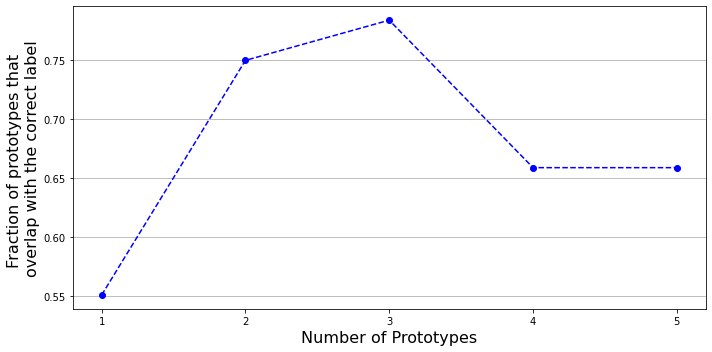

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = (1, 2, 3, 4, 5)
y = (
    0.5511363636363636,
    0.75,
    0.7840909090909091,
    0.6590909090909091,
    0.6590909090909091,
)

plt.plot(x, y, marker="o", linestyle="--", color="b")
plt.xlabel("Number of Prototypes", fontsize=16)
plt.ylabel("Fraction of prototypes that \noverlap with the correct label", fontsize=16)

plt.grid(axis="y")
plt.xticks(x)

plt.tight_layout()
plt.show()

In [18]:
summary_df["metric_5_overlap_with_correct_label_ratio_1"].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df["metric_5_overlap_with_correct_label_ratio_2"].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_5_overlap_with_correct_label_ratio_3"
].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_5_overlap_with_correct_label_ratio_4"
].apply(
    lambda x: x[0] > x[1]
).mean(), summary_df[
    "metric_5_overlap_with_correct_label_ratio_5"
].apply(
    lambda x: x[0] > x[1]
).mean()

(0.36363636363636365,
 0.5965909090909091,
 0.5227272727272727,
 0.4602272727272727,
 0.6590909090909091)

In [5]:
file = "BART_dbpedia_textfooler_0.9_0.9_0.9_16.json"
with open(os.path.join(log_directory, file)) as f:
    data = json.load(f)
    f.close()

In [42]:
attack_type = data["attack_type"]
results = data["results"]
prototypes = results["prototypes"]
prototypes_to_texts = {}
for i in range(len(prototypes[0]["best_train_egs"])):
    all_texts = [x[0] for x in prototypes[0]["best_train_egs"][str(i)]]
    prototypes_to_texts[i] = all_texts

prototype_to_corresponding_label = {}
for i in range(len(prototypes[0]["best_train_egs"])):
    all_labels = [x[1] for x in prototypes[0]["best_train_egs"][str(i)]]
    prototype_to_corresponding_label[i] = max(set(all_labels), key=all_labels.count)

tests = results["test"]
advs = results["adv"]

tests_predictions = np.array(tests[f"test_{attack_type}"]["all_predictions"])
tests_labels = np.array(tests[f"test_{attack_type}"]["all_correct_labels"])
tests_distances = np.array(tests[f"test_{attack_type}"]["best_protos_dists"])
tests_best_prototypes = np.array(tests[f"test_{attack_type}"]["best_protos"])
tests_best_prototypes_labels = []
for prototypes_list in tests_best_prototypes:
    tests_best_prototypes_labels.append(
        [prototype_to_corresponding_label[x] for x in prototypes_list]
    )
tests_best_prototypes_labels = np.array(tests_best_prototypes_labels)

advs_predictions = np.array(advs[f"adv_{attack_type}"]["all_predictions"])
advs_labels = np.array(advs[f"adv_{attack_type}"]["all_correct_labels"])
advs_distances = np.array(advs[f"adv_{attack_type}"]["best_protos_dists"])
advs_best_prototypes = np.array(advs[f"adv_{attack_type}"]["best_protos"])
advs_best_prototypes_labels = []
for prototypes_list in advs_best_prototypes:
    advs_best_prototypes_labels.append(
        [prototype_to_corresponding_label[x] for x in prototypes_list]
    )
advs_best_prototypes_labels = np.array(advs_best_prototypes_labels)

In [ ]:
test_csv_file = "datasets/dbpedia_dataset/test_textfooler.csv"
adv_csv_file = "datasets/dbpedia_dataset/adv_textfooler.csv"

test_csv_df = pd.read_csv(os.path.join(root_directory, test_csv_file))
adv_csv_df = pd.read_csv(os.path.join(root_directory, adv_csv_file))

In [ ]:
indices_where_both_test_prediction_and_adv_prediction_are_correct = np.where(
    np.logical_and(tests_predictions == tests_labels, advs_predictions == advs_labels)
    == True
)[0]

random_index = np.random.choice(
    indices_where_both_test_prediction_and_adv_prediction_are_correct
)

In [32]:
print("Random index: ", random_index)
# show the prototypes for the random index in the test set
print(
    "The label of the test example is:",
    tests_labels[random_index],
    "with the prediction:",
    tests_predictions[random_index],
    "and perturbed prediction:",
    advs_predictions[random_index],
)
print(tests_best_prototypes[random_index][:4])
print(tests_best_prototypes_labels[random_index][:4])

print(advs_best_prototypes[random_index][:4])
print(advs_best_prototypes_labels[random_index][:4])

print(test_csv_df.loc[random_index]["text"], test_csv_df.loc[random_index]["label"])
print(adv_csv_df.loc[random_index]["text"], adv_csv_df.loc[random_index]["label"])

Random index:  1764
The label of the test example is: 2 with the prediction: 2 and perturbed prediction: 2
[14  7 11  1]
[2 3 2 2]
[14  7 11  1]
[2 3 2 2]
The Gadsden Correctional Facility is a private state prison for women located in Quincy, Gadsden County, Florida, operated by Management and Training Corporation under contract with the Florida Department of Corrections. This facility was opened in 1995 and has a maximum capacity of 1544 prisoners. 2
The Gadsden Jails Services is a private state corrections for women located in Quincy, Gadsden County, Florida, operated by Management and Training Corporation under contract with the Florida Department of Corrections. This facility was opened in 1995 and has a maximum capacity of 1544 prisoners. 2


In [48]:
list(zip(prototypes_to_texts[14], [prototype_to_corresponding_label[14]] * 5))

[('The club was originally founded on 18 April 1948 by Karl Wolgert Nilsson, which would make them the oldest team in Sweden, thought it disbanded a number of times. After being inactive for a couple of years they reformed in 2010.',
  2),
 ('The Scott Bar Mountains are a mountain range in Siskiyou County, California. The area is named after gold miner John W. Scott who found a large gold nugget at what is now the town of Scott Bar.',
  2),
 ('The Western Rhaetian Alps (Italian: Alpi Retiche occidentali, German: Westliche Rätische Alpen) are a mountain range in the central part of the Alps.',
  2),
 ('Cerro de las Ánimas (\\"Hill of the Souls\\", formerly known as Mirador Nacional) is a peak and the second highest point of Uruguay, with an altitude of 501 metres (1,643.7 ft).',
  2),
 ('Bugis+, pronounced as Bugis Plus, formerly Iluma, is a 10 storey shopping mall which is a 5 minute walk from Bugis MRT station. It is located within the Bugis district of Singapore and opened its doors 

In [50]:
indices_where_correct_test_prediction_and_wrong_adv_prediction = np.where(
    np.logical_and(tests_predictions == tests_labels, advs_predictions != advs_labels)
    == True
)[0]

random_index = np.random.choice(
    indices_where_correct_test_prediction_and_wrong_adv_prediction
)

In [51]:
print("Random index: ", random_index)
# show the prototypes for the random index in the test set
print(
    "The label of the test example is:",
    tests_labels[random_index],
    "with the prediction:",
    tests_predictions[random_index],
    "and perturbed prediction:",
    advs_predictions[random_index],
)
print(tests_best_prototypes[random_index][:4])
print(tests_best_prototypes_labels[random_index][:4])

print(advs_best_prototypes[random_index][:4])
print(advs_best_prototypes_labels[random_index][:4])

print(test_csv_df.loc[random_index]["text"], test_csv_df.loc[random_index]["label"])
print(adv_csv_df.loc[random_index]["text"], adv_csv_df.loc[random_index]["label"])

Random index:  1317
The label of the test example is: 0 with the prediction: 0 and perturbed prediction: 2
[14 12  9  8]
[2 0 0 0]
[14  1  7 11]
[2 2 3 2]
KVTR is a commercial radio station in Victorville, California, broadcasting to the Victor Valley, California, area on 1590 AM. KVTR airs a ranchera music format branded as \"Victor 1590 AM\". 0
KVTR is a trades satellites terminus in Victorville, California, broadcasting to the Viktor Valley, California, area on 1590 AM. KVTR transmitting a ranchera electronica shapes marking as \"Victor 1590 AM\". 0


In [52]:
list(zip(prototypes_to_texts[14], [prototype_to_corresponding_label[14]] * 5))

[('The club was originally founded on 18 April 1948 by Karl Wolgert Nilsson, which would make them the oldest team in Sweden, thought it disbanded a number of times. After being inactive for a couple of years they reformed in 2010.',
  2),
 ('The Scott Bar Mountains are a mountain range in Siskiyou County, California. The area is named after gold miner John W. Scott who found a large gold nugget at what is now the town of Scott Bar.',
  2),
 ('The Western Rhaetian Alps (Italian: Alpi Retiche occidentali, German: Westliche Rätische Alpen) are a mountain range in the central part of the Alps.',
  2),
 ('Cerro de las Ánimas (\\"Hill of the Souls\\", formerly known as Mirador Nacional) is a peak and the second highest point of Uruguay, with an altitude of 501 metres (1,643.7 ft).',
  2),
 ('Bugis+, pronounced as Bugis Plus, formerly Iluma, is a 10 storey shopping mall which is a 5 minute walk from Bugis MRT station. It is located within the Bugis district of Singapore and opened its doors 